In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import yaml
import pprint
import os
import time
import numpy as np

# weights and biases for tracking of metrics
import wandb 

# make the plots inline again
%matplotlib inline

# sometimes have to activate this to plot plots in notebook
import matplotlib

from code import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### evaluation with and without proposal distribution

In [2]:
# high dpi plots are commented out

from matplotlib.ticker import MaxNLocator    
from matplotlib.ticker import PercentFormatter
from tqdm import tqdm

def relative_diff(quantity, A):
    return np.abs(np.array(quantity) - np.abs(torch.det(A).cpu().numpy())) / np.abs(torch.det(A).cpu().numpy())

def get_ELBO(ldj, log_f_s):  
    return ldj + log_f_s

def get_log_f_s(A, s):
    """Calculate  -log f(s) with s ~ q"""
    
    dim = A.shape[0]
    s = s.unsqueeze(-1)

    return - dim * torch.log(torch.norm(torch.matmul(A, s).squeeze(-1), dim=1))

def evaluate_det_estimate(model, A, max_samples):
    BATCH_SIZE = 1000

    abs_det_A = torch.abs(torch.det(A)).cpu().numpy()
    log_abs_det_A = torch.slogdet(A)[1].cpu().numpy()

    print(f'Matrix of size {A.shape[0]}')
    print(f'true abs determinant {abs_det_A}')
    print(f'true log determinant {log_abs_det_A} \n')

    log_surface = log_surface_hypersphere(n_dim_sphere = A.shape[0] - 1, r=1)


    vanilla_det_estimates = []
    det_estimates = []
    log_det_estimates = []
    log_det_ELBO = []
    log_det_IWBO = []

    range_ = range(2, max_samples)
    
    torch.manual_seed(42)
    
    dim = A.shape[0]

    for exp in range_:

        print(f'at 10^{exp} samples')

        nr_samples = 10 ** exp

        ldj = torch.tensor([]).to(device)
        s = torch.tensor([]).to(device)
        s_0 = torch.tensor([]).to(device)

        for iter_ in tqdm(range(int(np.ceil(nr_samples / BATCH_SIZE)))):

            nr_samples_ = min(nr_samples, BATCH_SIZE)

            s_0_batch = torch.randn(nr_samples_, dim).to(device)
            s_0_batch = s_0_batch / torch.norm(s_0_batch, dim=1, keepdim=True)

            with torch.no_grad():
                s_batch, ldj_batch, _ = model(s_0_batch)

            s = torch.cat([s, s_batch], dim=0)
            s_0 = torch.cat([s_0, s_0_batch], dim=0)            

            ldj = torch.cat([ldj, ldj_batch])        

        log_f_s = get_log_f_s(A, s) 
        
#         print(f' with s0 {get_log_f_s(A, s_0).mean()}')
        

        ELBO = get_ELBO(ldj, log_f_s)
        
#         print(f' ELBO with s {ELBO.mean()}')
        
        # direct estimates
        vanilla_det_estimate = 1 / get_log_f_s(A, s_0).exp().mean()
        det_estimate = 1 / ELBO.exp().mean()
        log_det_estimate = - torch.logsumexp(ELBO, dim = 0) + torch.log(torch.tensor(nr_samples).float())

        vanilla_det_estimates.append(vanilla_det_estimate)
        det_estimates.append(det_estimate)
        log_det_estimates.append(log_det_estimate)
        log_det_ELBO.append(-ELBO.mean())
        
        
    return vanilla_det_estimates, det_estimates, log_det_estimates, log_det_ELBO, range_


def plot_estimates_all(vanilla_det_estimates,
                       det_estimates, 
                       A,
                       model_name,
                       log_det_estimates, 
                       log_det_ELBO, 
                       range_):        

    abs_det_A = torch.abs(torch.det(A)).cpu().numpy()
    log_abs_det_A = torch.slogdet(A)[1].cpu().numpy()
    
    path = 'det_estimate_model/16D/'
    os.makedirs(path, exist_ok=True)   
    
    nr_samples = 10 ** list(range_)[-1]
    markersize = 10
    
#     fig = plt.figure(dpi=300)
    plt.plot(range_, vanilla_det_estimates, 'tab:orange',label = 'Monte Carlo estimate', marker = 'o', markersize=markersize) 
    plt.plot(range_, det_estimates, 'blue', label = 'Var. det. estimate', marker = 'x', markersize=markersize)
    plt.plot(range_, np.abs([abs_det_A] * (max_samples-2)), 'red', linestyle='--', label= 'True det.')
    plt.grid()
    plt.yscale('log')
    plt.ylim(bottom = 1)
    plt.gca().set_xlabel("$10^x$ Nr of samples")
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))       
    plt.legend()    
    plt.savefig(path + f"{model_name}_det_estimates.svg")
    plt.show()

    print(f'Last estimate w/o proposal {vanilla_det_estimates[-1]:.2f} for dim {dim} based on {nr_samples} samples')
    print(f'Last estimate w/ proposal {det_estimates[-1]:.2f} for dim {dim} based on {nr_samples} samples \n')
  
#     fig = plt.figure(dpi=300)
    rel_diff_det_est = relative_diff(det_estimates, A)
    rel_diff_vanilla_det_est = relative_diff(vanilla_det_estimates, A)

    plt.plot(range_, rel_diff_vanilla_det_est * 100, 'tab:orange', label = 'Monte Carlo estimate', marker = 'o', markersize=markersize)
    plt.plot(range_, rel_diff_det_est * 100, 'blue', label = 'Var. det. estimate', marker = 'x', markersize=markersize)
   
    plt.grid()   
    plt.yscale('log')    

    plt.gca().yaxis.set_major_formatter(PercentFormatter(decimals=1))
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))     
    plt.gca().set_xlabel("$10^x$ Nr of samples")
    plt.legend()
    plt.savefig(path + f"{model_name}_rel_difference.svg")
    plt.show()

    print(f'Last rel diff w/o proposal {(rel_diff_vanilla_det_est[-2] * 100):.2f} % for dim {dim} based on {nr_samples} samples')
    print(f'Last rel diff w/ proposal {(rel_diff_det_est[-1] * 100):.2f} % for dim {dim} based on {nr_samples} samples \n')

#     plt.plot(range_, log_det_ELBO, label = 'ELBO')
#     plt.plot(range_, np.abs([log_abs_det_A] * (max_samples-2)), '--',label= 'true det')
#     plt.grid()    
#     plt.gca().set_xlabel("$10^x$ Nr of samples")
#     plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))     
#     plt.legend()
#     plt.show()
    
    return rel_diff_det_est, rel_diff_vanilla_det_est
    
    


------

## 16 $\times$ 16 matrix

### load matrix

In [3]:
A = np.load('det_estimate_model/16D/matrix.npy')
A = torch.tensor(A).to(device)
A.shape

torch.Size([16, 16])

### load model 

In [4]:
NUM_CENTERS = 12
NUM_BINS = 16
NUM_FLOWS_COU = 8
NUM_DIM_DATA = 16
dim = NUM_DIM_DATA
CAP_HOUSEHOLDER_REFL = False
BATCH_SIZE = 1024

In [5]:
#### cylindrical moebius

model_name = 'cyl_cou_moeb'

### cou cylindrical moebius model
cyl_cou_moeb = Cylindrical_Flow(num_flows=NUM_FLOWS_COU,
                                 num_bins=NUM_BINS, 
                                 flow_type='moebius',
                                 num_dim_data=NUM_DIM_DATA, 
                                 mask_type='coupling',
                                 add_phase_translation=False,
                                 num_centers=NUM_CENTERS)

cyl_cou_moeb.to(device)

optimizer_cyl_cou = optim.AdamW(cyl_cou_moeb.parameters())



state = torch.load(f'det_estimate_model/16D/{model_name}_v5.t7')

cyl_cou_moeb.load_state_dict(state['state_dict'])
optimizer_cyl_cou.load_state_dict(state['optimizer'])

ELBO_list = np.load(f'det_estimate_model/16D/ELBO_list_{model_name}_v5.npy',allow_pickle=True)
dj_list = np.load(f'det_estimate_model/16D/dj_list_{model_name}_v5.npy',allow_pickle=True)


AssertionError: Torch not compiled with CUDA enabled

### Plot estimates

### evaluate cylindrical moebius from $10^2$ till $10^5$ samples

In [6]:
max_samples = 6

vanilla_det_estimates, det_estimates_cyl, log_det_estimates, log_det_ELBO, range_ =  evaluate_det_estimate(cyl_cou_moeb, 
                                                                                                           A, 
                                                                                                           max_samples)

  0%|          | 0/10 [00:00<?, ?it/s]

Matrix of size 16
true abs determinant 7.705254554748535
true log determinant 2.0419023036956787 

at 10^2 samples
at 10^3 samples
at 10^4 samples


  2%|▏         | 2/100 [00:00<00:04, 19.96it/s]

at 10^5 samples


100%|██████████| 100/100 [00:04<00:00, 20.05it/s]


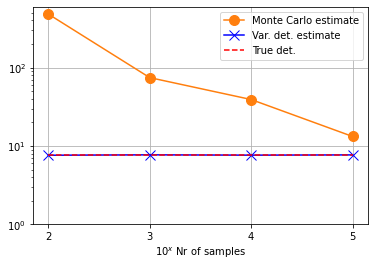

Last estimate w/o proposal 13.21 for dim 16 based on 100000 samples
Last estimate w/ proposal 7.69 for dim 16 based on 100000 samples 



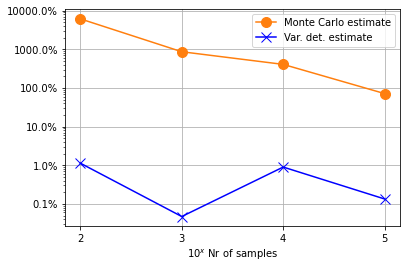

Last rel diff w/o proposal 407.24 % for dim 16 based on 100000 samples
Last rel diff w/ proposal 0.13 % for dim 16 based on 100000 samples 



In [7]:
model_name = 'cyl_cou_moeb'

rel_diff_det_est, rel_diff_vanilla_det_est = plot_estimates_all(vanilla_det_estimates, 
                                                                det_estimates_cyl, 
                                                                A,
                                                                model_name, 
                                                                log_det_estimates, 
                                                                log_det_ELBO, 
                                                                range_)


### calculate metrics

#### true det estimate

In [8]:
abs_det_A = torch.abs(torch.det(A)).cpu().numpy()
abs_det_A

array(7.7052546, dtype=float32)

#### absolute det estimates

In [9]:
np.round(np.array(vanilla_det_estimates).astype(float),2)


array([481.09,  74.37,  39.08,  13.21])

In [10]:
np.round(np.array(det_estimates_cyl).astype(float),2)

array([7.62, 7.71, 7.64, 7.69])

#### relative difference estimate

In [11]:
np.round(np.array(rel_diff_det_est * 100).astype(float),1)

array([1.1, 0. , 0.9, 0.1])

In [12]:
np.round(np.array(rel_diff_vanilla_det_est * 100).astype(float),0)

array([6144.,  865.,  407.,   71.])

#### log det estimates

In [13]:
np.round(np.log(np.array(vanilla_det_estimates).astype(float)),2)

array([6.18, 4.31, 3.67, 2.58])

In [14]:
np.round(np.log(np.array(det_estimates_cyl).astype(float)),2)

array([2.03, 2.04, 2.03, 2.04])

In [15]:
np.round(np.log(abs_det_A),2)

2.04

----

## 10 $\times$ 10 matrix


### create plot for averages over different runs in 10D

We used only the absolute values in tabular form and none of the plots in the VDE paper for 10 $\times$ 10 matrix

In [12]:
! pwd

/Users/simon/Documents/AI_Master/MSc Thesis/_git_repo_msc_thesis


In [6]:
def load_model(model_name, idx):
    
    NUM_CENTERS = 12
    NUM_BINS = 16
    NUM_FLOWS_COU = 8
    NUM_DIM_DATA = 10
    CAP_HOUSEHOLDER_REFL = False
    BATCH_SIZE = 1024
    
    
    ### cou cylindrical moebius model
    cyl_cou_moeb = Cylindrical_Flow(num_flows=NUM_FLOWS_COU,
                                     num_bins=NUM_BINS, 
                                     flow_type='moebius',
                                     num_dim_data=NUM_DIM_DATA, 
                                     mask_type='coupling',
                                     add_phase_translation=False,
                                     num_centers=NUM_CENTERS)

    cyl_cou_moeb.to(device)

    optimizer_cyl_cou = optim.AdamW(cyl_cou_moeb.parameters())

    state = torch.load(f'det_estimate_model/10D/{model_name}_{idx}.t7')
    print('state iter',state['iter_'])

    cyl_cou_moeb.load_state_dict(state['state_dict'])
    print('loading_done')
    
    return cyl_cou_moeb

def relative_diff(quantity, A):
    return np.abs(np.array(quantity) - np.abs(torch.det(A).cpu().numpy())) / np.abs(torch.det(A).cpu().numpy())


In [7]:
### print determinants of 10 x 10 matrices
for idx in range(0,5):
    
    print('idx',idx)
    
    A = np.load(f'det_estimate_model/10D/matrix_in_10d_{idx}.npy')
    A = torch.tensor(A).to(device)
    
    print(torch.det(A))
    print()
    

idx 0
tensor(-520.3585)

idx 1
tensor(-748.6776)

idx 2
tensor(945.0228)

idx 3
tensor(3000.4995)

idx 4
tensor(-252.2948)



In [18]:
### evalaute matrices
### not used in the VDE paper

max_samples = 6

total_rel_diff_vanilla_det_est = np.array([]).reshape(0, max_samples - 2)
total_rel_diff_det_est = np.array([]).reshape(0, max_samples - 2)

for idx in range(0,5):
    
    print()
    print('#### NEW MATRIX ####')
    print()
    
    model_name = 'cyl_moeb'
    
    cyl_cou_moeb = load_model(model_name, idx)
    
    A = np.load(f'det_estimate_model/10D/matrix_in_10d_{idx}.npy')
    A = torch.tensor(A).to(device)
    

    vanilla_det_estimates, det_estimates_cyl, log_det_estimates, log_det_ELBO, range_ =  evaluate_det_estimate(cyl_cou_moeb, 
                                                                                                               A, 
                                                                                                               max_samples)  
    
    rel_diff_vanilla_det_est = relative_diff(vanilla_det_estimates, A)
    rel_diff_det_est = relative_diff(det_estimates_cyl, A)    
    
    print()
    print('absolute estimates')
    print(np.array(vanilla_det_estimates).astype(float))
    print(np.array(det_estimates_cyl).astype(float))
    print('True det')
    print(np.array(torch.det(A).cpu()).astype(float))
    print()
    print('relative errors')
    print(np.array(rel_diff_vanilla_det_est).astype(float)*100)
    print(np.array(rel_diff_det_est).astype(float)*100)
    print()
    
    total_rel_diff_vanilla_det_est = np.vstack([total_rel_diff_vanilla_det_est, rel_diff_vanilla_det_est])
    total_rel_diff_det_est = np.vstack([total_rel_diff_det_est, rel_diff_det_est])    
    
total_rel_diff_vanilla_det_est_perc = np.array(total_rel_diff_vanilla_det_est).astype(float) * 100
total_rel_diff_det_est_perc = np.array(total_rel_diff_det_est).astype(float) * 100


  0%|          | 0/10 [00:00<?, ?it/s]


#### NEW MATRIX ####

state iter 9800
loading_done
Matrix of size 10
true abs determinant 520.3585205078125
true log determinant 6.254518032073975 

at 10^2 samples
at 10^3 samples
at 10^4 samples


  3%|▎         | 3/100 [00:00<00:04, 20.88it/s]

at 10^5 samples


  0%|          | 0/10 [00:00<?, ?it/s]


absolute estimates
[3283.64916992 1492.23486328 1068.90661621  702.6763916 ]
[486.69332886 529.26708984 511.13635254 518.74920654]
True det
-520.3585205078125

relative errors
[531.03590012 186.77053452 105.41733503  35.03697217]
[6.4696148  1.71200614 1.77227203 0.30927022]


#### NEW MATRIX ####

state iter 9800
loading_done
Matrix of size 10
true abs determinant 748.6776733398438
true log determinant 6.618308067321777 

at 10^2 samples
at 10^3 samples
at 10^4 samples


  3%|▎         | 3/100 [00:00<00:04, 20.89it/s]

at 10^5 samples


  0%|          | 0/1 [00:00<?, ?it/s]


absolute estimates
[1172.7331543  2004.31677246 1501.07397461  902.86590576]
[774.46539307 757.62915039 744.44067383 748.72497559]
True det
-748.6776733398438

relative errors
[ 56.6405952  167.71425009 100.49669743  20.5947414 ]
[3.44443545 1.19563835 0.56593106 0.00631811]


#### NEW MATRIX ####

state iter 9800
loading_done
Matrix of size 10
true abs determinant 945.022705078125
true log determinant 6.851208686828613 

at 10^2 samples
at 10^3 samples


 30%|███       | 3/10 [00:00<00:00, 20.78it/s]

at 10^4 samples


  3%|▎         | 3/100 [00:00<00:04, 20.90it/s]

at 10^5 samples


  0%|          | 0/10 [00:00<?, ?it/s]


absolute estimates
[2864.17358398 6713.83105469 2313.60253906 1586.23669434]
[931.79241943 956.20422363 947.55206299 937.8560791 ]
True det
945.022705078125

relative errors
[203.07986736 610.44125557 144.81977224  67.8516984 ]
[1.3999965  1.183201   0.26765047 0.75835488]


#### NEW MATRIX ####

state iter 9800
loading_done
Matrix of size 10
true abs determinant 3000.49951171875
true log determinant 8.006534576416016 

at 10^2 samples
at 10^3 samples
at 10^4 samples


  3%|▎         | 3/100 [00:00<00:04, 20.75it/s]

at 10^5 samples


  0%|          | 0/10 [00:00<?, ?it/s]


absolute estimates
[5018.49365234 4823.13867188 4585.33056641 3977.86767578]
[2977.00219727 3053.95922852 2882.90356445 2994.75488281]
True det
3000.49951171875

relative errors
[67.25527048 60.744524   52.81890631 32.57351518]
[0.78311339 1.78169385 3.91921215 0.19145574]


#### NEW MATRIX ####

state iter 9800
loading_done
Matrix of size 10
true abs determinant 252.29483032226562
true log determinant 5.5305986404418945 

at 10^2 samples
at 10^3 samples
at 10^4 samples


  3%|▎         | 3/100 [00:00<00:04, 20.75it/s]

at 10^5 samples


100%|██████████| 100/100 [00:04<00:00, 20.75it/s]



absolute estimates
[4812.24121094 2053.73071289  542.72479248  599.93170166]
[264.81253052 259.52926636 248.20454407 252.32803345]
True det
-252.29483032226562

relative errors
[1807.38792419  714.02015686  115.11530876  137.78992891]
[4.96153645 2.86745317 1.62123274 0.01316045]



In [19]:
def plot_averages(total_rel_diff_vanilla,
                   total_rel_diff):
    
#     fig = plt.figure(dpi=300)    
    nr_exps = total_rel_diff_vanilla.shape[1]                         
    range_ = range(2, nr_exps + 2)
    
    vanilla_mean = np.mean(total_rel_diff_vanilla, axis=0)
    var_det_mean = np.mean(total_rel_diff, axis=0)
    
    print('means')
    print(vanilla_mean)
    print(var_det_mean)
    
    vanilla_std = np.std(total_rel_diff_vanilla,axis=0)
    var_det_std = np.std(total_rel_diff,axis=0)
    
    print()
    print('std')
    print(vanilla_std)  
    print(var_det_std)     
    print()
        
    plt.errorbar(range_, vanilla_mean, vanilla_std, color= 'tab:orange', label='MC estimate')
    plt.errorbar(range_, var_det_mean, var_det_std, color = 'blue', label='Var. det. estimate')                  
    
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))    
    plt.yscale('log')    
    
    plt.legend()    
    plt.ylim(bottom = 0.1)
    
    plt.gca().set_xlabel("$10^x$ Nr of samples")
    plt.gca().yaxis.set_major_formatter(PercentFormatter())
    
    path = 'det_estimate_model/10D/'
        
    plt.grid()
    plt.savefig(path + "averages.svg")
    
    plt.show()

    

means
[533.07991147 347.93814421 103.73360395  58.76937121]
[3.41173932 1.7479985  1.62925969 0.25571188]

std
[659.8109027  262.24406547  29.74301726  42.50526839]
[2.13121215 0.61314069 1.28444904 0.275926  ]



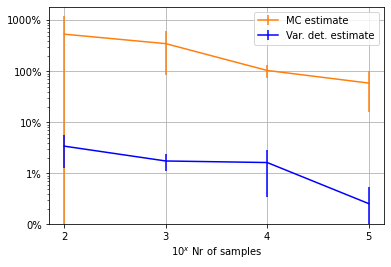

In [20]:
# not used in vde paper
plot_averages(total_rel_diff_vanilla_det_est_perc, 
              total_rel_diff_det_est_perc)

### plot metrics in terms of mean estimates and std. 

Those were used in the VDE paper

#### mean and std of vanilla

In [21]:
np.round(np.mean(total_rel_diff_vanilla_det_est_perc,axis=0),0)

array([533., 348., 104.,  59.])

In [22]:
np.round(np.std(total_rel_diff_vanilla_det_est_perc,axis=0),0)

array([660., 262.,  30.,  43.])

#### mean and std of var det estimate

In [23]:
np.round(np.mean(total_rel_diff_det_est_perc,axis=0),1)

array([3.4, 1.7, 1.6, 0.3])

In [24]:
np.round(np.std(total_rel_diff_det_est_perc,axis=0),1)

array([2.1, 0.6, 1.3, 0.3])

--- 

### evaluate model and proposal density in 3D

In [25]:
def evaluate_model(model, nr_gridpoints, x_conditioner = None):
    
    # evaluate model via numerical approximation. Only works for num_dim_data == 3

    eps = 1e-2 # for numerical stability at unfolding
    phi_linspace = np.linspace(-np.pi, np.pi, nr_gridpoints)
    theta_linspace = np.linspace(-np.pi/2 + eps, np.pi/2 - eps, nr_gridpoints)

    x_vec = torch.zeros([nr_gridpoints, nr_gridpoints, 3]).to(device)
    cos_vec = torch.zeros([nr_gridpoints, nr_gridpoints]).to(device)
    
    if x_conditioner is not None:
        _x_conditioner = x_conditioner.view(-1, 784).repeat(nr_gridpoints ** 2, 1)
    else:
        _x_conditioner = None

    for i, phi0 in enumerate(phi_linspace):

        for j, theta0 in enumerate(theta_linspace):

            # transform to cartesian coordiantes 
            x = torch.tensor(T_spherical_to_cartesian(phi0,theta0)).float().to(device)

            # x_vec shape (nr_gridpoints, nr_gridpoints, 3)
            x_vec[j,i] = x
            cos_vec[j,i] = np.cos(theta0)

    # obtain log dj for mesh grid
    model.eval()
    with torch.no_grad():
    
        _, ldj_vec, _ = model(x=x_vec.view(-1,3), x_conditioner = _x_conditioner, inverse=True)

    dphi = phi_linspace[1] - phi_linspace[0]
    dtheta = theta_linspace[1] - theta_linspace[0]
    
    ldj_vec = ldj_vec.detach().cpu().numpy().reshape(nr_gridpoints,nr_gridpoints)
    cos_vec = cos_vec.detach().cpu().numpy()
    
    # this model density is used for plotting
    model_density = 1 / (4 * np.pi) * np.exp(ldj_vec)
    
    # this model density is used for sum to one check
    model_density_with_cos = model_density * cos_vec

    print()
    print('Evaluate and plot model')
    print(f'Sum to one check {np.sum(model_density_with_cos) * dphi * dtheta}')

    return model_density


def plot_model_density(model_density, 
                       idx, 
                       path,
                       nr_gridpoints):
    
    """
    Args:
        phi_mu_list: list of phi coordinates of centers 
        theta_mu_list: list of theta coordinates of centers 
    """
    
    phi_linspace = np.linspace(-np.pi, np.pi, nr_gridpoints)
    theta_linspace = np.linspace(-np.pi/2, np.pi/2, nr_gridpoints)

    RAD = 180 / np.pi
    
    levels_contourf = 50
    
    # Model density plot
    
    X,Y = np.meshgrid(phi_linspace, theta_linspace)
    fig = plt.figure(figsize=(15,7),dpi=300)

    ax = fig.add_subplot(121)
    ax.grid(linestyle='--')

    m = Basemap(ax=ax, projection='moll',lon_0=0,lat_0=0,resolution='c')
    cnt = m.contourf(X*RAD, Y*RAD, 
               model_density, 
               levels=levels_contourf, 
               cmap=plt.cm.jet,
               latlon=True)
    
    # This is the fix for the white lines between contour levels when using high resol images like svg or pdf
    for c in cnt.collections:
        c.set_edgecolor("face")    
    
    
    
    m.drawparallels(np.arange(-90.,120.,15.),labels=[1,0,0,0],labelstyle='+/-',color = 'white') # draw parallels
    m.drawmeridians(np.arange(0.,420.,30.),labels=[0,0,0,0],color = 'white')
    
    ax = fig.add_subplot(122)
    ax.grid(linestyle='--')
    cnt2 = ax.contourf(phi_linspace/np.pi, theta_linspace/np.pi, 
                model_density, 
                levels = levels_contourf, 
                cmap = plt.cm.jet, 
                extend='both')
    # This is the fix for the white lines between contour levels when using high resol images like svg or pdf
    for c in cnt2.collections:
        c.set_edgecolor("face")      
    
    
    plt.gca().xaxis.set_major_formatter(tck.FormatStrFormatter('%g $\pi$'))
    plt.gca().xaxis.set_major_locator(tck.MultipleLocator(base=0.25))
    plt.gca().yaxis.set_major_formatter(tck.FormatStrFormatter('%g $\pi$'))
    plt.gca().yaxis.set_major_locator(tck.MultipleLocator(base=0.2))
    
    plt.savefig("det_estimate_model/" + path + ".svg", format='svg')
#     plt.savefig("det_estimate_model/" + path + ".png", format='png')    
#     plt.savefig("det_estimate_model/" + path + ".pdf", format='pdf')        
    
    plt.show()
    
    

def eval_and_plot_model(model, 
                        idx, 
                        path,
                        nr_gridpoints):
        
        model_density = evaluate_model(model, nr_gridpoints,x_conditioner = None)    
        
        plot_model_density(model_density, 
                           idx,
                           path,
                           nr_gridpoints)
    
def get_log_f_s(A, s):
    """Calculate  -log f(s) with s ~ q"""

    dim = A.shape[0]
    s = s.unsqueeze(-1)

    return - dim * torch.log(torch.norm(torch.matmul(A, s).squeeze(-1), dim=1))

In [27]:
seed = 15

print(seed)

torch.manual_seed(seed)
A = torch.randn(3,3).to(device)
print()
print(A)
print(torch.eig(A))

15

tensor([[-0.7056,  0.6741, -0.5454],
        [ 0.9107,  1.0682,  0.1424],
        [-1.2754, -0.1769,  1.0084]], device='cuda:0')
torch.return_types.eig(
eigenvalues=tensor([[-1.2758,  0.0000],
        [ 1.5401,  0.0000],
        [ 1.1066,  0.0000]], device='cuda:0'),
eigenvectors=tensor([], device='cuda:0'))




### evaluate densities again


In [28]:


def eval_densities(max_num, path):

    idx = 1
    print()
    print(f'current id {idx}')
    print()

    A = np.load(f'det_estimate_model/{path}/matrix_in_3d_{idx}.npy')
    A = torch.tensor(A).to(device)

    print(A)

    #### cyl moeb

    model_name = 'cyl_ar_spline'

    ### cou cylindrical moebius model
    cyl_cou_moeb = Cylindrical_Flow(num_flows=NUM_FLOWS_COU,
                                     num_bins=NUM_BINS, 
                                     flow_type='spline',
                                     num_dim_data=NUM_DIM_DATA, 
                                     mask_type='autoregressive',
                                     add_phase_translation=False,
                                     num_centers=NUM_CENTERS)

    cyl_cou_moeb.to(device)

    state = torch.load(f'det_estimate_model/{path}/{model_name}_in_3d_{idx}.t7')

    cyl_cou_moeb.load_state_dict(state['state_dict'])
    print('loading done') 

    print('path',path)

    eval_and_plot_model(cyl_cou_moeb, 
                        idx,
                        path = path + f'/{model_name}_proposal_{idx}',
                        nr_gridpoints = 100)



### model density


current id 1

tensor([[-0.7056,  0.6741, -0.5454],
        [ 0.9107,  1.0682,  0.1424],
        [-1.2754, -0.1769,  1.0084]], device='cuda:0')
loading done
path 3D

Evaluate and plot model
Sum to one check 1.0070542678857364


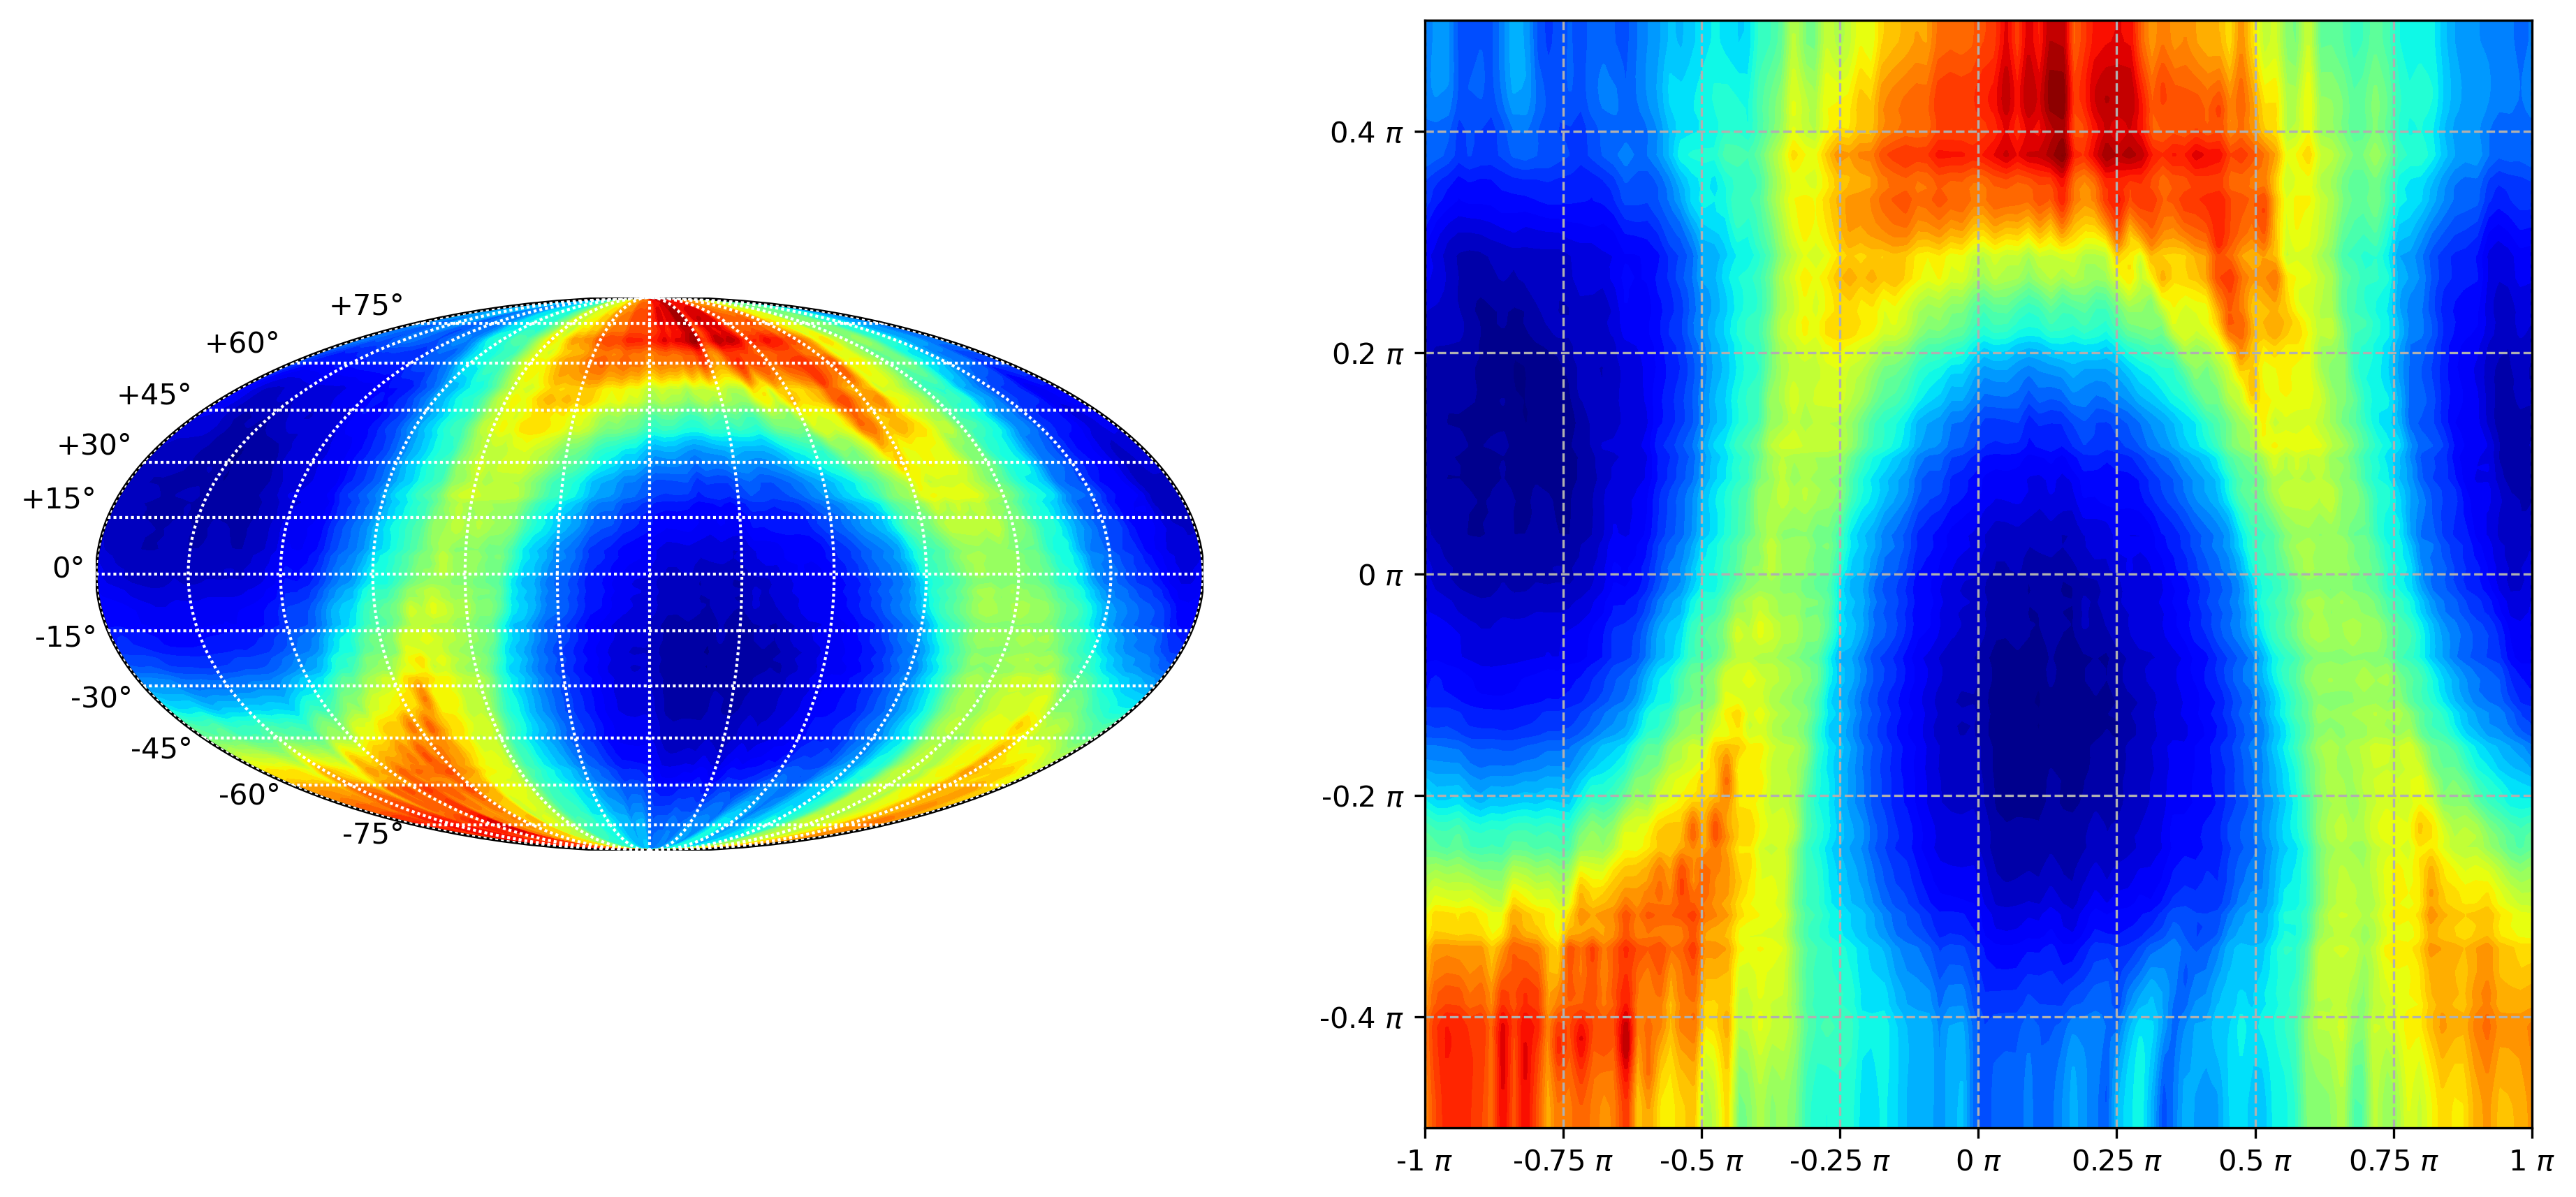

In [29]:
NUM_CENTERS = 12
NUM_BINS = 32
NUM_FLOWS_COU = 6

NUM_DIM_DATA = 3
CAP_HOUSEHOLDER_REFL = False
BATCH_SIZE = 1024


eval_densities(max_num=5, path='3D')

### true proposal

15
[[-0.70564395  0.67411864 -0.54535866]
 [ 0.91072273  1.0681953   0.14239322]
 [-1.2753724  -0.17689072  1.0084069 ]]


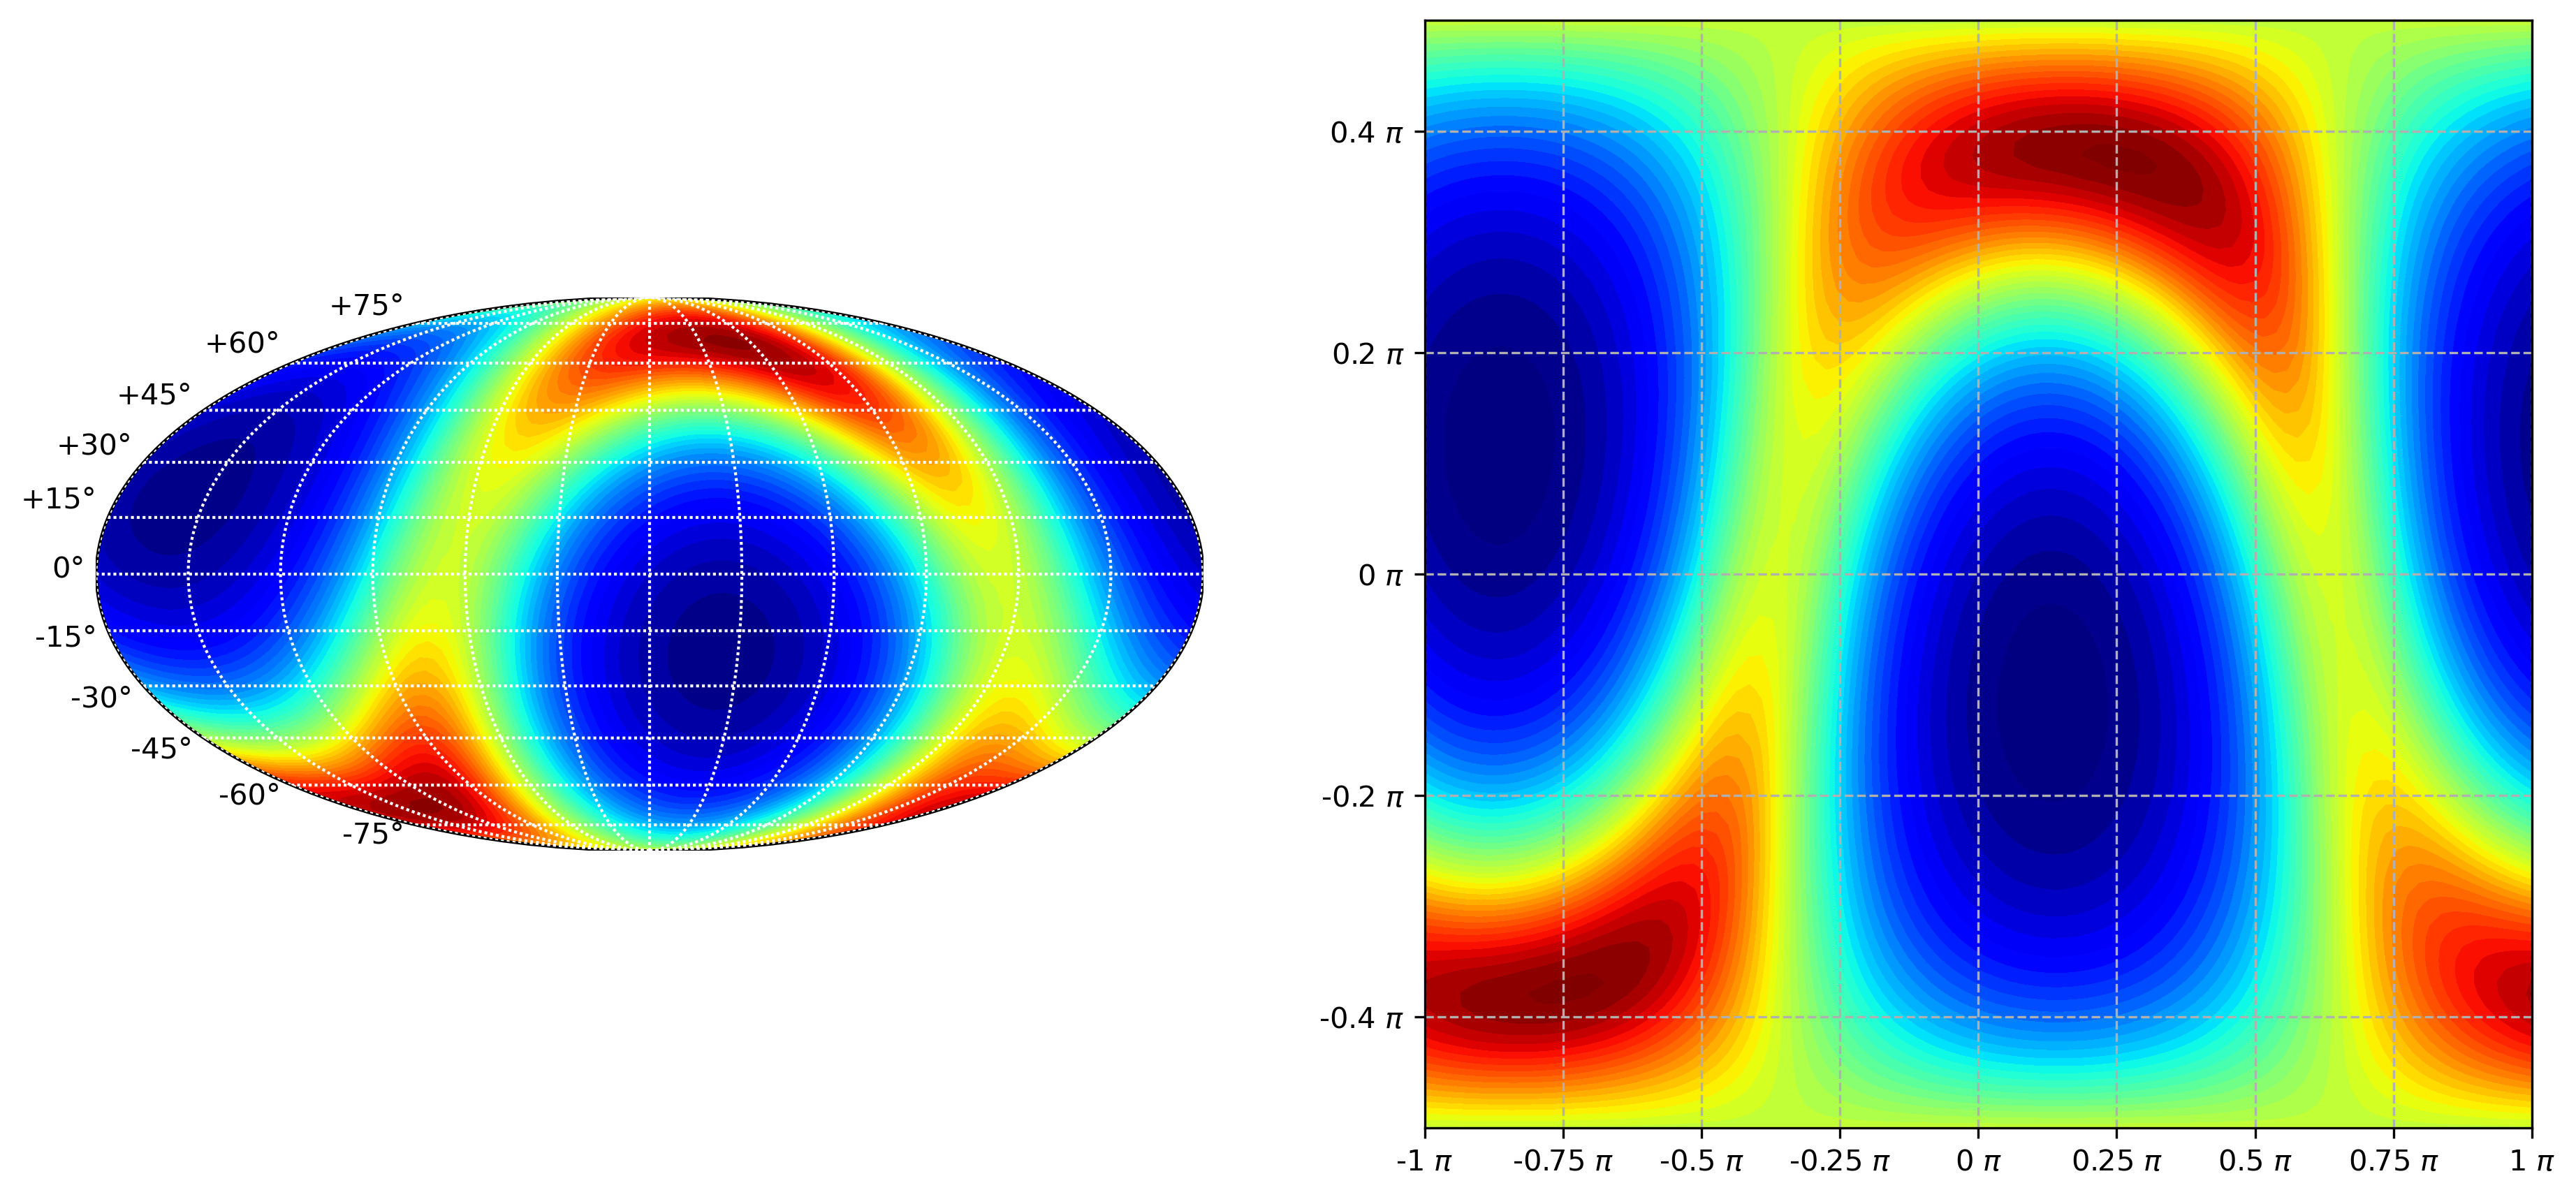

In [34]:
nr_gridpoints = 100

phi_linspace = np.linspace(-np.pi, np.pi, nr_gridpoints)
theta_linspace = np.linspace(-np.pi/2, np.pi/2, nr_gridpoints)

x_vec = torch.zeros([nr_gridpoints, nr_gridpoints, 3]).to(device)

for i, phi0 in enumerate(phi_linspace):

    for j, theta0 in enumerate(theta_linspace):

        # transform to cartesian coordiantes 
        x = torch.tensor(T_spherical_to_cartesian(phi0,theta0)).float().to(device)

        # x_vec shape (nr_gridpoints, nr_gridpoints, 3)
        x_vec[j,i] = x
        
x_vec.shape       

seed = 15 
    
print(seed)

torch.manual_seed(seed)
A = torch.randn(3,3).to(device)
print(A.cpu().detach().numpy())
density = torch.exp(get_log_f_s(A, x_vec.view(-1,3))) * 100 
density = density.reshape(nr_gridpoints, nr_gridpoints)
density = density.detach().cpu().numpy()


plot_model_density(density, 
                   idx=0,
                   path = '3D/opt_proposal_1',
                   nr_gridpoints=100)

----

### convert 10 x 10 matrice to latex matrix

In [31]:
torch.manual_seed(15)
A = torch.randn(3,3).to(device)

print(A)

tensor([[-0.7056,  0.6741, -0.5454],
        [ 0.9107,  1.0682,  0.1424],
        [-1.2754, -0.1769,  1.0084]], device='cuda:0')


In [32]:
def bmatrix(a):
    """Returns a LaTeX bmatrix

    :a: numpy array
    :returns: LaTeX bmatrix as a string
    """
    if len(a.shape) > 2:
        raise ValueError('bmatrix can at most display two dimensions')
    lines = str(a).replace('[', '').replace(']', '').splitlines()
    rv = [r'\begin{bmatrix}']
    rv += ['  ' + ' & '.join(l.split()) + r'\\' for l in lines]
    rv +=  [r'\end{bmatrix}']
    return '\n'.join(rv)

In [33]:
for idx in range(0,5):
    
    print('idx',idx)
    
    A = np.load(f'det_estimate_model/10D/matrix_in_10d_{idx}.npy')
    A = torch.tensor(A).to(device)
    
    print(np.round(torch.det(A).detach().cpu().numpy(),2))
    
    A = np.round(np.array(A.cpu()).astype(float),2)
    
    print(bmatrix(A))
    print()
    

idx 0
-520.36
\begin{bmatrix}
  -1.08 & -0.6 & 0.06 & 0.71 & -0.81 & 0.57 & 0.69 & 0.51 & -0.94 & 0.18\\
  -0.55 & 1.5 & 1.39 & -0.18 & -0.56 & -0.05 & 0.98 & 1.82 & 1.48 & 0.01\\
  -0.26 & -2.07 & -1.12 & -0.27 & -1.03 & 0.97 & -1.84 & -0.5 & -0.47 & -1.17\\
  1.01 & -1.25 & 1.71 & 1.24 & -0.79 & -0.17 & -1.05 & 0.44 & 0.02 & 0.04\\
  1.24 & -0.31 & -0.18 & -0.74 & -0.43 & 0.29 & -0.67 & 1.43 & -1.01 & -0.17\\
  -0.49 & -1.17 & 0.43 & 1.4 & 1.28 & 1.8 & -0.45 & 1.67 & -0.93 & -1.72\\
  0.78 & 1.19 & 0.02 & -0.06 & 0.72 & -1.24 & -1.19 & -0.71 & 1.73 & 0.81\\
  0.53 & 1.56 & -1.09 & 0.33 & -0.29 & -0.47 & 1.02 & 1.67 & -0.17 & 0.26\\
  1.16 & -0.18 & 0.86 & 0.94 & 0.26 & -1.64 & -0.38 & -0.31 & -0.79 & 1.31\\
  0.54 & 1.39 & -0.21 & -0.12 & 0.14 & 0.8 & 0.78 & 0.85 & -1.3 & -0.41\\
\end{bmatrix}

idx 1
-748.68
\begin{bmatrix}
  -1.92 & -0.19 & 0.34 & 0.41 & -0.58 & -2.08 & 0.29 & -0.46 & -1.37 & -0.45\\
  -0.56 & 0.71 & 0.06 & 0.17 & 1.44 & -1.81 & -1.19 & 1.02 & -2.84 & 2.28\\
  1.64 